# Introduction
This is a notebook using machine learning to output the schedule of suppliers.
First import the data in the form of a csv file. The input of the model will be a date and the output will be a list of days corresponding to the schedule of the suppliers and when they will arrive next.

# Imports

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import datetime

# Load Dataset

In [2]:
filepath = 'supplier_schedule.csv'#supplier schedule on local drive
#filepath = '/content/drive/MyDrive/Documents/uni_work/Bangkit2023/capstone/supplier_schedule.csv'
df = pd.read_csv(filepath, dtype = {'supplier':str,'tanggal':str})
df['supplier'] = df['supplier'].str.replace(' ','')
#remove all punctuation from the supplier names
df['supplier'] = df['supplier'].str.replace('.','')



# Data Transformation

Transform the code of suppliers into their tokenized forms using the tokenizer.

In [3]:
#multi_hot encode the suppliers based of the date and if they visited on that date or not
#df['supplier'] = np.array([i[0] for i in supplier_sequence],dtype = np.int64)

multi_hot = pd.get_dummies(df, columns = ['supplier'],prefix = '', prefix_sep = '')
multi_hot = multi_hot.groupby('tanggal').sum()
multi_hot = multi_hot.reset_index()
multi_hot

,tanggal,AB,ABA,ABD,ABK,ABS,ADR,AFDHAL,AG,AI,...,UTJ,VG,WOI,WT,YENI,YIP,YS,YUSRA,ZAIMAR,ZULFAINI
0,2022-01-03,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1,2022-01-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-01-05,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2022-01-06,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-01-07,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,2023-03-28,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
386,2023-03-29,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
387,2023-03-30,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
388,2023-03-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#convert date to epoch
epoch = pd.to_datetime(multi_hot['tanggal'], format = "%Y-%m-%d")
epoch = (epoch - datetime.datetime(1970,1,1))
epoch = epoch.map(lambda x: x.total_seconds())
multi_hot['tanggal'] = epoch
multi_hot


,tanggal,AB,ABA,ABD,ABK,ABS,ADR,AFDHAL,AG,AI,...,UTJ,VG,WOI,WT,YENI,YIP,YS,YUSRA,ZAIMAR,ZULFAINI
0,1.641168e+09,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1,1.641254e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.641341e+09,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1.641427e+09,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1.641514e+09,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,1.679962e+09,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
386,1.680048e+09,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
387,1.680134e+09,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
388,1.680221e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#sort from multi_hot date
multi_hot = multi_hot.sort_values('tanggal', ascending= True)
multi_hot = multi_hot.reset_index()
multi_hot.pop('index')
multi_hot

,tanggal,AB,ABA,ABD,ABK,ABS,ADR,AFDHAL,AG,AI,...,UTJ,VG,WOI,WT,YENI,YIP,YS,YUSRA,ZAIMAR,ZULFAINI
0,1.641168e+09,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1,1.641254e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.641341e+09,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1.641427e+09,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1.641514e+09,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,1.679962e+09,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
386,1.680048e+09,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
387,1.680134e+09,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
388,1.680221e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#add previous date column
def previous_date(dataframe):
  """
  Adds a column containing the previous date
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    df (dataframe): dataframe containing the previous date
  """
  dataframe['previous_tanggal'] = dataframe['tanggal'].shift(1)
  return dataframe
multi_hot = previous_date(multi_hot)


In [7]:
#Get the time difference between the current date and the previous date and convert it to days, keep the first row as 0
def time_diff(dataframe):
  """
  Adds a column containing the time difference between the current date and the previous date
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    df (dataframe): dataframe containing the time difference between the current date and the previous date
  """
  dataframe['time_diff'] = abs(dataframe['tanggal'] - dataframe['previous_tanggal'])
  dataframe['time_diff'] = dataframe['time_diff'].map(lambda x: x / 86400)
  dataframe['time_diff'] = dataframe['time_diff'].fillna(1)
  return dataframe
multi_hot = time_diff(multi_hot)
multi_hot.pop('previous_tanggal')


0               NaN
1      1.641168e+09
2      1.641254e+09
3      1.641341e+09
4      1.641427e+09
           ...     
385    1.679875e+09
386    1.679962e+09
387    1.680048e+09
388    1.680134e+09
389    1.680221e+09
Name: previous_tanggal, Length: 390, dtype: float64

In [8]:
#dictionary of sum of 1s for each supplier
def supplier_dict(dataframe):
  """
  Creates a dictionary containing the sum of 1s for each supplier
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    supplier_dict (dict): dictionary containing the sum of 1s for each supplier
  """
  supplier_dict = {}
  for i in range(1, len(dataframe.columns)):
    supplier_dict[dataframe.columns[i]] = dataframe[dataframe.columns[i]].sum()
  return supplier_dict
supplier_dict = supplier_dict(multi_hot)
supplier_dict

{'AB': 2,
 'ABA': 102,
 'ABD': 22,
 'ABK': 5,
 'ABS': 23,
 'ADR': 69,
 'AFDHAL': 3,
 'AG': 10,
 'AI': 13,
 'AJL': 1,
 'AJSB': 10,
 'AJW': 95,
 'ALBACAR': 21,
 'ALFA': 9,
 'ANI': 11,
 'ANIS': 9,
 'AP': 8,
 'APL': 12,
 'APS': 28,
 'AQILLA': 10,
 'ARB': 1,
 'ARTA': 21,
 'ASI': 13,
 'ASIH': 76,
 'ASNIAHK': 15,
 'AWM': 12,
 'AYU': 2,
 'BA': 7,
 'BCRS': 28,
 'BENTOL': 4,
 'BERKAH': 2,
 'BHK': 40,
 'BM': 52,
 'BMC': 5,
 'BML': 27,
 'BSM': 22,
 'BSP': 26,
 'BUKWATI': 35,
 'BUNDA': 14,
 'CADO': 5,
 'CD': 124,
 'CK': 4,
 'CMPG': 17,
 'COLA': 64,
 'CR': 54,
 'DB': 34,
 'DBA': 33,
 'DBBP': 8,
 'DBT': 45,
 'DMA': 14,
 'DP': 1,
 'DS': 48,
 'EB': 36,
 'ECN': 3,
 'ELBIRUNI': 8,
 'ELKA': 28,
 'ELSIE': 51,
 'ELYANA': 26,
 'ENSEVAL': 52,
 'ERNA': 7,
 'ESSE': 46,
 'FAJAR': 123,
 'FD': 24,
 'FIKRI': 4,
 'FJA': 1,
 'FORTUNA': 7,
 'FWI': 11,
 'GA': 2,
 'GB': 20,
 'GBK': 1,
 'GERAI': 7,
 'GJP': 19,
 'GMP': 87,
 'GPD': 15,
 'HAJ': 12,
 'HASANAH': 4,
 'HERI': 22,
 'HERMAN': 29,
 'HILAL': 7,
 'IAP': 37,
 'ICA': 

In [9]:
#swap values of 0 and 1 in the first row of the dataframe (because the first row is the lamultihot date for supplier visits)
def swap_0_1(dataframe):
  """
  Swaps the values of 0 and 1 in the first row of the dataframe
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    df (dataframe): dataframe containing the swapped values of 0 and 1 in the first row of the dataframe
  """
  for i in range(1, len(dataframe.columns)):
    if dataframe.iloc[0,i] == 0:
      dataframe.iloc[0,i] = -1
    else:
      dataframe.iloc[0,i] = 0
  return dataframe
multi_hot = swap_0_1(multi_hot)
multi_hot

,tanggal,AB,ABA,ABD,ABK,ABS,ADR,AFDHAL,AG,AI,...,VG,WOI,WT,YENI,YIP,YS,YUSRA,ZAIMAR,ZULFAINI,time_diff
0,1.641168e+09,-1,-1,-1,-1,-1,-1,-1,-1,0,...,0,-1,-1,-1,-1,-1,-1,-1,-1,0.0
1,1.641254e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,1.641341e+09,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1.0
3,1.641427e+09,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1.0
4,1.641514e+09,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,1.679962e+09,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1.0
386,1.680048e+09,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1.0
387,1.680134e+09,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1.0
388,1.680221e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [10]:
#update each column
def days_since_last_visit(dataframe):
  """
  Adds a column containing the days till the next visit
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    df (dataframe): dataframe containing the since last visit limited to a max of 365
  """
  dataframe = dataframe.copy()
  for i in range(1, len(dataframe.columns)-1):
    for j in range(1, len(dataframe)):
      if dataframe.iloc[j,i] == 0 and dataframe.iloc[j - 1,i] == -1:
        dataframe.iloc[j,i] = -1
      elif dataframe.iloc[j,i] == 0:
        dataframe.iloc[j,i] = dataframe.iloc[j - 1,i] + dataframe.iloc[j,dataframe.columns.get_loc('time_diff')]
      else:
        dataframe.iloc[j,i] = 0
  return dataframe
days_diff = days_since_last_visit(multi_hot)
days_diff

,tanggal,AB,ABA,ABD,ABK,ABS,ADR,AFDHAL,AG,AI,...,VG,WOI,WT,YENI,YIP,YS,YUSRA,ZAIMAR,ZULFAINI,time_diff
0,1.641168e+09,-1,-1,-1,-1,-1,-1,-1,-1,0,...,0,-1,-1,-1,-1,-1,-1,-1,-1,0.0
1,1.641254e+09,-1,-1,-1,-1,-1,-1,-1,-1,1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,1.0
2,1.641341e+09,-1,-1,-1,-1,-1,-1,-1,-1,2,...,0,-1,-1,-1,-1,-1,-1,-1,-1,1.0
3,1.641427e+09,-1,0,-1,-1,-1,0,-1,0,3,...,1,-1,-1,-1,-1,-1,-1,-1,-1,1.0
4,1.641514e+09,-1,1,0,-1,-1,1,-1,1,4,...,2,-1,0,-1,-1,-1,-1,-1,-1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,1.679962e+09,91,0,7,99,43,3,7,14,133,...,0,13,5,382,3,18,13,223,29,1.0
386,1.680048e+09,92,1,8,100,44,4,8,15,134,...,0,14,6,383,4,19,14,224,30,1.0
387,1.680134e+09,93,0,9,101,45,5,9,16,135,...,1,0,7,384,5,0,15,225,31,1.0
388,1.680221e+09,94,1,10,102,46,6,10,17,136,...,2,1,8,385,6,1,16,226,32,1.0


In [11]:
#Remove any columns of suppliers that have not visited in the last 186 days or if all the rows are -1
def remove_unvisited(dataframe):
  """
  Removes any columns of suppliers that have not visited in the last 186 days or if all the rows are -1
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    df (dataframe): dataframe containing the suppliers that have visited in the last 186 days
  """
  changed = dataframe.copy()
  for i in range(1, len(dataframe.columns)-1):
    if dataframe.iloc[-1,i] == -1:
      dataframe.pop(dataframe.columns[i])
  return dataframe
days_diff = remove_unvisited(days_diff)
days_diff.pop('time_diff')
multi_hot.pop('time_diff')

0      0.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
385    1.0
386    1.0
387    1.0
388    1.0
389    1.0
Name: time_diff, Length: 390, dtype: float64

In [12]:
def supplier_tokenizer(supplier):
  """
  Instantiates the tokenizer for the supplier codes
  Args:
    supplier (list): upper case list of supplier codes

  Returns:
    tokenizer (object): an instance of the Tokenizer class containing the dict
  """

  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(supplier)

  index = tokenizer.word_index
  sequence = tokenizer.texts_to_sequences(supplier)

  return index, sequence

supplier_index, supplier_sequence = supplier_tokenizer(multi_hot.columns[1:])

print(supplier_index)





{'ab': 1, 'aba': 2, 'abd': 3, 'abk': 4, 'abs': 5, 'adr': 6, 'afdhal': 7, 'ag': 8, 'ai': 9, 'ajl': 10, 'ajsb': 11, 'ajw': 12, 'albacar': 13, 'alfa': 14, 'ani': 15, 'anis': 16, 'ap': 17, 'apl': 18, 'aps': 19, 'aqilla': 20, 'arb': 21, 'arta': 22, 'asi': 23, 'asih': 24, 'asniahk': 25, 'awm': 26, 'ayu': 27, 'ba': 28, 'bcrs': 29, 'bentol': 30, 'berkah': 31, 'bhk': 32, 'bm': 33, 'bmc': 34, 'bml': 35, 'bsm': 36, 'bsp': 37, 'bukwati': 38, 'bunda': 39, 'cado': 40, 'cd': 41, 'ck': 42, 'cmpg': 43, 'cola': 44, 'cr': 45, 'db': 46, 'dba': 47, 'dbbp': 48, 'dbt': 49, 'dma': 50, 'dp': 51, 'ds': 52, 'eb': 53, 'ecn': 54, 'elbiruni': 55, 'elka': 56, 'elsie': 57, 'elyana': 58, 'enseval': 59, 'erna': 60, 'esse': 61, 'fajar': 62, 'fd': 63, 'fikri': 64, 'fja': 65, 'fortuna': 66, 'fwi': 67, 'ga': 68, 'gb': 69, 'gbk': 70, 'gerai': 71, 'gjp': 72, 'gmp': 73, 'gpd': 74, 'haj': 75, 'hasanah': 76, 'heri': 77, 'herman': 78, 'hilal': 79, 'iap': 80, 'ica': 81, 'ida': 82, 'ig': 83, 'ila': 84, 'ina': 85, 'inn': 86, 'ip': 

In [13]:
#rename columns to supplier codes from supplier index
def rename_columns(dataframe):
  """
  Renames the columns to supplier codes from supplier index
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    df (dataframe): dataframe containing the renamed columns
  """
  dataframe = dataframe.copy()
  for i in range(1, len(dataframe.columns)):
    dataframe = dataframe.rename(columns = {dataframe.columns[i]: supplier_index[dataframe.columns[i].lower()]})
  return dataframe
renamed = rename_columns(multi_hot)
renamed

,tanggal,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1.641168e+09,-1,-1,-1,-1,-1,-1,-1,-1,0,...,-1,0,-1,-1,-1,-1,-1,-1,-1,-1
1,1.641254e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.641341e+09,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1.641427e+09,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1.641514e+09,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,1.679962e+09,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
386,1.680048e+09,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
387,1.680134e+09,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
388,1.680221e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#convert dataframe to tensor
def convert_to_tensor(dataframe):
  """
  Converts the dataframe to a tensor
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    df (tensor): tensor containing the dataframe
  """
  tensor = tf.convert_to_tensor(dataframe)
  return tensor
renamed = convert_to_tensor(renamed)
renamed

<tf.Tensor: shape=(390, 200), dtype=float64, numpy=
array([[ 1.6411680e+09, -1.0000000e+00, -1.0000000e+00, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       [ 1.6412544e+09,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.6413408e+09,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 1.6801344e+09,  0.0000000e+00,  1.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.6802208e+09,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.6803072e+09,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]])>

In [23]:
#split first column of tensor into features and rest into labels
def split_tensor(dataframe):
  """
  Splits the first column of the tensor into features and rest into labels
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    df (tensor): tensor containing the features and labels
  """
  features = dataframe[:,0]
  labels = dataframe[:,1:]
  return features, labels
features, labels = split_tensor(renamed)
features


<tf.Tensor: shape=(390,), dtype=float64, numpy=
array([1.6411680e+09, 1.6412544e+09, 1.6413408e+09, 1.6414272e+09,
       1.6415136e+09, 1.6416000e+09, 1.6417728e+09, 1.6418592e+09,
       1.6419456e+09, 1.6420320e+09, 1.6421184e+09, 1.6422048e+09,
       1.6423776e+09, 1.6424640e+09, 1.6425504e+09, 1.6426368e+09,
       1.6427232e+09, 1.6428096e+09, 1.6429824e+09, 1.6430688e+09,
       1.6431552e+09, 1.6432416e+09, 1.6433280e+09, 1.6434144e+09,
       1.6435872e+09, 1.6436736e+09, 1.6437600e+09, 1.6438464e+09,
       1.6439328e+09, 1.6440192e+09, 1.6441920e+09, 1.6442784e+09,
       1.6443648e+09, 1.6444512e+09, 1.6445376e+09, 1.6446240e+09,
       1.6447968e+09, 1.6448832e+09, 1.6449696e+09, 1.6450560e+09,
       1.6451424e+09, 1.6452288e+09, 1.6453152e+09, 1.6454016e+09,
       1.6454880e+09, 1.6455744e+09, 1.6456608e+09, 1.6457472e+09,
       1.6458336e+09, 1.6460064e+09, 1.6460928e+09, 1.6461792e+09,
       1.6462656e+09, 1.6463520e+09, 1.6464384e+09, 1.6466112e+09,
       1.64669

In [25]:
#create tensor dataset
def create_dataset(features, labels):
  """
  Creates a tensor dataset
  Args:
    features (tensor): tensor containing the features
    labels (tensor): tensor containing the labels

  Returns:
    dataset (object): an instance of the TensorSliceDataset class
  """
  dataset = tf.data.Dataset.from_tensor_slices((features, labels))
  return dataset
dataset = create_dataset(features, labels)
dataset


<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(199,), dtype=tf.float64, name=None))>

# Model Architecture

In [15]:
#create a model with variable learning rate
def create_model(learning_rate):
  """
  Creates a model with variable learning rate
  Args:
    learning_rate (float): learning rate for the model

  Returns:
    model (object): an instance of the Sequential class
  """
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(supplier_index), activation='sigmoid')
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss='BinaryCrossentropy',
                metrics=['accuracy'])
  return model


In [16]:
#compile models with different learning rates
learning_rates = [0.001, 0.01, 0.1, 0.2, 0.3]
models = []
for learning_rate in learning_rates:
  models.append(create_model(learning_rate))

#determine the best learning rate
histories = []
for model in models:
  history = model.fit(train_dataset.batch(1), epochs=10, validation_data=val_dataset.batch(1), verbose=1)
  histories.append(history)


Epoch 1/10
312/312 [==============================] - 3s 3ms/step - loss: 768911.3125 - accuracy: 0.0032 - val_loss: 0.6371 - val_accuracy: 0.0000e+00
Epoch 2/10
312/312 [==============================] - 1s 2ms/step - loss: 0.5848 - accuracy: 0.0032 - val_loss: 0.5391 - val_accuracy: 0.0000e+00
Epoch 3/10
312/312 [==============================] - 1s 3ms/step - loss: 0.4978 - accuracy: 0.0000e+00 - val_loss: 0.4649 - val_accuracy: 0.0000e+00
Epoch 4/10
312/312 [==============================] - 1s 2ms/step - loss: 0.4339 - accuracy: 0.0032 - val_loss: 0.4104 - val_accuracy: 0.0000e+00
Epoch 5/10
312/312 [==============================] - 1s 2ms/step - loss: 0.3853 - accuracy: 0.0000e+00 - val_loss: 0.3671 - val_accuracy: 0.0000e+00
Epoch 6/10
312/312 [==============================] - 1s 2ms/step - loss: 0.3511 - accuracy: 0.0000e+00 - val_loss: 0.3408 - val_accuracy: 0.0000e+00
Epoch 7/10
312/312 [==============================] - 1s 2ms/step - loss: 0.3221 - accuracy: 0.0032 - val_l

# Analysis

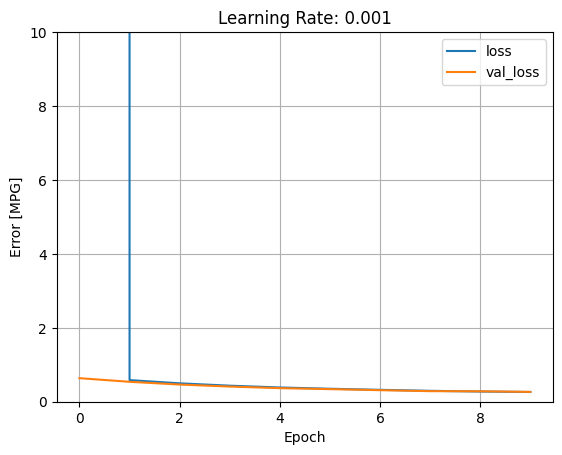

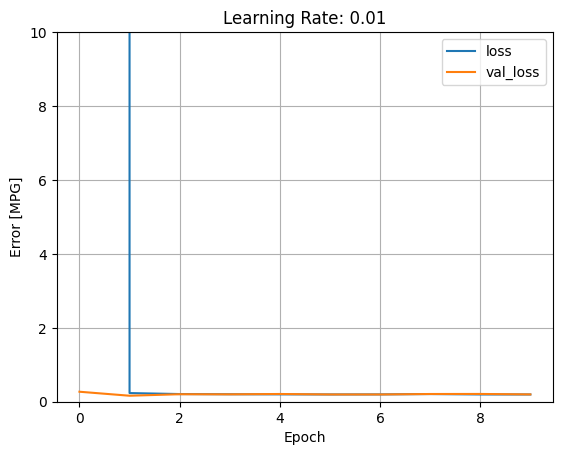

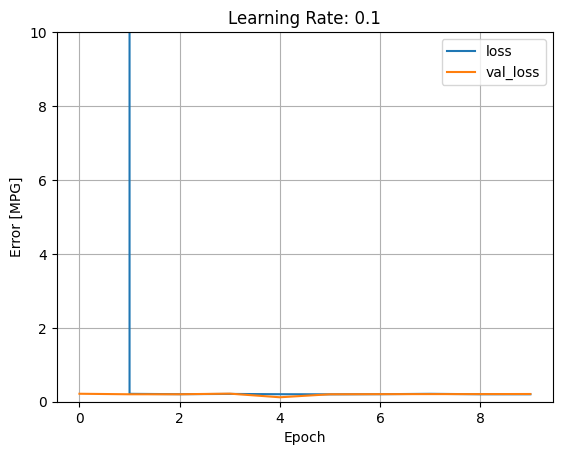

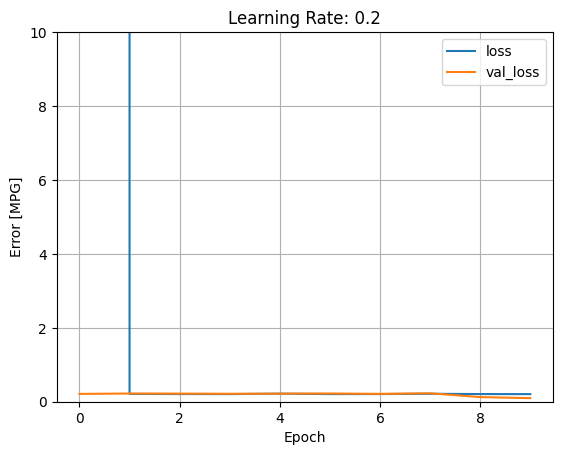

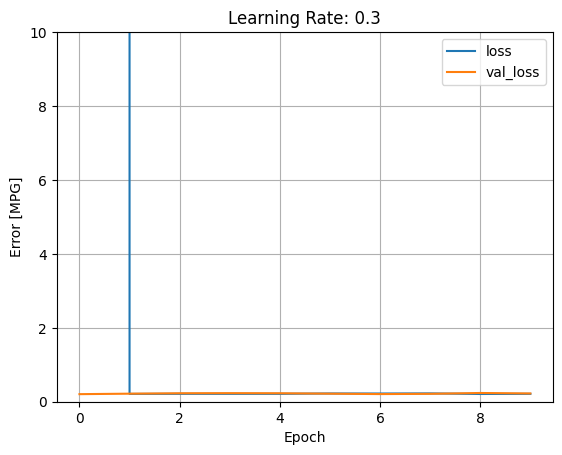

In [17]:
#plot the loss and accuracy for each learning rate
def plot_loss(history):
  """
  Plots the loss and accuracy for each learning rate
  Args:
    history (object): an instance of the History class

  Returns:
    None
  """
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.ylim([0, 10])
  plt.legend()
  plt.grid(True)

for i in range(len(histories)):
    plot_loss(histories[i])
    plt.title('Learning Rate: ' + str(learning_rates[i]))
    plt.show()



In [18]:
#choose the best learning rate
best_learning_rate = 0.001
best_model = create_model(best_learning_rate)
best_model.fit(train_dataset.batch(1), epochs=100, validation_data=val_dataset.batch(1), verbose=1)


Epoch 1/100
312/312 [==============================] - 2s 3ms/step - loss: 705407.0000 - accuracy: 0.0064 - val_loss: 46493.2773 - val_accuracy: 0.0000e+00
Epoch 2/100
312/312 [==============================] - 1s 2ms/step - loss: 6616.2686 - accuracy: 0.0032 - val_loss: 0.5702 - val_accuracy: 0.0000e+00
Epoch 3/100
312/312 [==============================] - 1s 2ms/step - loss: 0.5233 - accuracy: 0.0000e+00 - val_loss: 0.4861 - val_accuracy: 0.0000e+00
Epoch 4/100
312/312 [==============================] - 1s 2ms/step - loss: 0.4528 - accuracy: 0.0032 - val_loss: 0.4223 - val_accuracy: 0.0000e+00
Epoch 5/100
312/312 [==============================] - 1s 2ms/step - loss: 0.3999 - accuracy: 0.0032 - val_loss: 0.3825 - val_accuracy: 0.0000e+00
Epoch 6/100
312/312 [==============================] - 1s 3ms/step - loss: 0.3562 - accuracy: 0.0032 - val_loss: 0.3422 - val_accuracy: 0.0000e+00
Epoch 7/100
312/312 [==============================] - 1s 2ms/step - loss: 0.3246 - accuracy: 0.0000e+

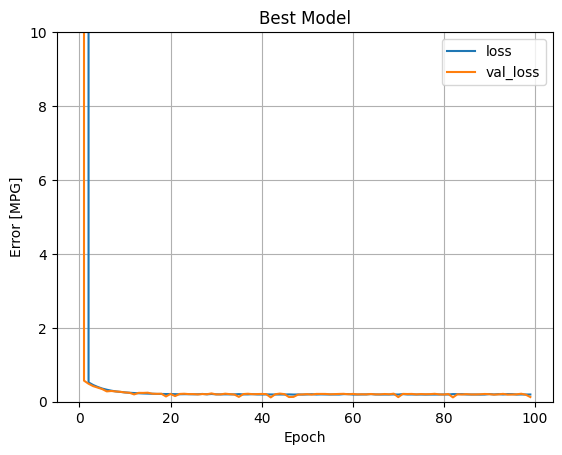

In [19]:
#plot the loss and accuracy for the best model
plot_loss(best_model.history)
plt.title('Best Model')
plt.show()

In [20]:
#evaluate the best model on the test dataset
loss, accuracy = best_model.evaluate(test_dataset.batch(1), verbose=1)
print("Accuracy", accuracy)


39/39 [==============================] - 0s 2ms/step - loss: 0.2028 - accuracy: 0.0000e+00
Accuracy 0.0


In [21]:
#predict the next visit for each supplier
def predict_next_visit(dataframe):
  """
  Predicts the next visit for each supplier
  Args:
    dataframe (dataframe): dataframe containing the dates

  Returns:
    df (dataframe): dataframe containing the predicted next visit for each supplier
  """
  dataframe = dataframe.copy()
  for i in range(1, len(dataframe.columns)):
    dataframe.iloc[-1,i] = best_model.predict(dataframe.iloc[-1,0])
  return dataframe
predicted = predict_next_visit(renamed)
predicted


IndexError: tuple index out of range